# Smogseer training at 100 epochs

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

In [2]:
# Load your dataset
ds = xr.open_dataset('S5PL2_5D.nc')
ds


<xarray.Dataset> Size: 2GB
Dimensions:         (time: 366, lat: 291, lon: 512, bnds: 2)
Coordinates:
  * lat             (lat) float64 2kB 34.36 34.33 34.3 ... 24.97 24.94 24.9
  * lon             (lon) float64 4kB 68.15 68.19 68.22 ... 84.75 84.79 84.82
  * time            (time) datetime64[ns] 3kB 2019-01-03T12:00:00 ... 2024-01...
    time_bnds       (time, bnds) datetime64[ns] 6kB ...
Dimensions without coordinates: bnds
Data variables:
    AER_AI_340_380  (time, lat, lon) float32 218MB ...
    AER_AI_354_388  (time, lat, lon) float32 218MB ...
    CH4             (time, lat, lon) float32 218MB ...
    CLOUD_FRACTION  (time, lat, lon) float32 218MB ...
    CO              (time, lat, lon) float32 218MB ...
    HCHO            (time, lat, lon) float32 218MB ...
    NO2             (time, lat, lon) float32 218MB ...
    O3              (time, lat, lon) float32 218MB ...
    SO2             (time, lat, lon) float32 218MB ...
Attributes:
    Conventions:               CF-1.7
    title:                     S5PL2 Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-05-02T13:00:01.155492
    time_coverage_start:       2019-01-01T00:00:00+00:00
    time_coverage_end:         2024-01-05T00:00:00+00:00
    time_coverage_duration:    P1830DT0H0M0S
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        68.137207
    geospatial_lat_min:        24.886436
    geospatial_lon_max:        84.836426
    geospatial_lat_max:        34.37759367382812

In [3]:
# Stack the features into a single DataArray
features = ['SO2', 'NO2', 'CH4', 'O3', 'CO', 'HCHO']
data = xr.concat([ds[feature] for feature in features], dim='feature')
data = data.transpose('time', 'lat', 'lon', 'feature')

# Convert to NumPy arrays
X_data = data.values.astype(np.float32)

# Normalize the input data
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data.reshape(-1, X_data.shape[-1])).reshape(X_data.shape)

# Impute nan values with the mean of the respective feature
X_data_reshaped = X_data.reshape(-1, X_data.shape[-1])
imputer = SimpleImputer(strategy='mean')
X_data_imputed = imputer.fit_transform(X_data_reshaped)
X_data_imputed = X_data_imputed.reshape(X_data.shape)

# Add the time dimension to the input data
X_data_imputed = np.expand_dims(X_data_imputed, axis=1)

# Load your actual target data
ds_target = xr.open_dataset('S5PL2_5D.nc')
target_data = ds_target['AER_AI_340_380'].values.astype(np.float32)

# Normalize target data to [0, 1]
target_scaler = MinMaxScaler()
target_data = target_scaler.fit_transform(target_data.reshape(-1, 1)).reshape(target_data.shape)

# Impute nan values in target data
target_data_reshaped = target_data.reshape(-1, target_data.shape[-1])
target_data_imputed = imputer.fit_transform(target_data_reshaped)
target_data_imputed = target_data_imputed.reshape(target_data.shape)

# Ensure the target data shape is (num_samples, num_timesteps, num_latitudes, num_longitudes, 1)
target_data_imputed = target_data_imputed.reshape((target_data.shape[0], 1, target_data.shape[1], target_data.shape[2], 1))

# Remove samples with nan values in target data
non_nan_target_indices = ~np.isnan(target_data_imputed).any(axis=(1, 2, 3, 4))
X_data_clean = X_data_imputed[non_nan_target_indices]
y_data_clean = target_data_imputed[non_nan_target_indices]

# Ensure target values are within the valid range [0, 1]
print("Target data range: ", y_data_clean.max(), y_data_clean.min())

# Split data into training and validation sets
split_ratio = 0.8
split_idx = int(split_ratio * X_data_clean.shape[0])

X_train, X_val = X_data_clean[:split_idx], X_data_clean[split_idx:]
y_train, y_val = y_data_clean[:split_idx], y_data_clean[split_idx:]


Target data range:  1.0 0.0


In [4]:
print("Input shape:", X_data_clean.shape)
print("Target shape:", y_data_clean.shape)
print("Max and Min of Target Data:", y_data_clean.max(), y_data_clean.min())

Input shape: (366, 1, 291, 512, 6)
Target shape: (366, 1, 291, 512, 1)
Max and Min of Target Data: 1.0 0.0


In [5]:
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)

Training data shape: (292, 1, 291, 512, 6)
Validation data shape: (74, 1, 291, 512, 6)
Training target shape: (292, 1, 291, 512, 1)
Validation target shape: (74, 1, 291, 512, 1)


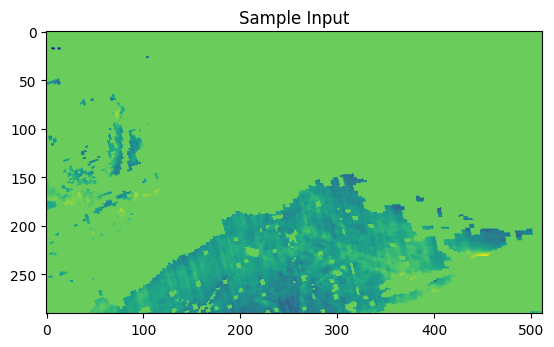

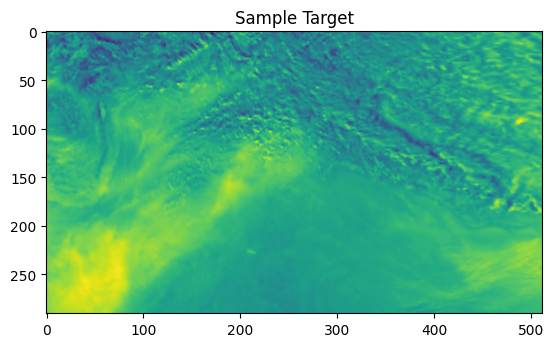

In [6]:
import matplotlib.pyplot as plt

# Visualize a sample from the training data
sample_index = 0
plt.imshow(X_train[sample_index, 0, :, :, 2], cmap='viridis')
plt.title('Sample Input')
plt.show()

plt.imshow(y_train[sample_index, 0, :, :, 0], cmap='viridis')
plt.title('Sample Target')
plt.show()


In [31]:
np.save("X_val.npy", X_val)
np.save("Y_val.npy", y_val)

In [7]:
# Define the model with correct input shape
inp = layers.Input(shape=(1, X_data_clean.shape[2], X_data_clean.shape[3], X_data_clean.shape[4]))

x = layers.BatchNormalization()(inp)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
    recurrent_activation="sigmoid",
    kernel_initializer="glorot_uniform"
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
    recurrent_activation="sigmoid",
    kernel_initializer="glorot_uniform"
)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x, name="smogseer")

# Use a reduced learning rate and gradient clipping
optimizer = keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=optimizer,
    metrics=['mean_squared_error']
)

# Print the model summary
model.summary()

# Data Generator Class

class DataGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indices = np.arange(X_data.shape[0])
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_X = self.X_data[batch_indices]
        batch_y = self.y_data[batch_indices]
        return batch_X, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

batch_size = 1
train_generator = DataGenerator(X_train, y_train, batch_size)
val_generator = DataGenerator(X_val, y_val, batch_size)

# Define callbacks for monitoring and adjusting learning rate
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-7
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, verbose=1, restore_best_weights=True
    ),
    keras.callbacks.TensorBoard(log_dir='./logs')
]

# Train the model using data generators
history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=callbacks)
# Save the model
model.save('smogseer.keras')


Model: "smogseer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 291, 512, 6) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 291, 512, 6) │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 291, 512,    │        12,736 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 291, 512,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 291, 512,    │        55,424 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 291, 512,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 291, 512, 1) │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,241 (270.47 KB)

 Trainable params: 69,133 (270.05 KB)

 Non-trainable params: 108 (432.00 B)

Epoch 1/100


c:\Users\khant\Documents\smogseer\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


292/292 ━━━━━━━━━━━━━━━━━━━━ 143s 472ms/step - loss: 0.7290 - mean_squared_error: 0.1448 - val_loss: 0.6891 - val_mean_squared_error: 0.1320 - learning_rate: 1.0000e-05
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 137s 469ms/step - loss: 0.7017 - mean_squared_error: 0.1329 - val_loss: 0.6959 - val_mean_squared_error: 0.1347 - learning_rate: 1.0000e-05
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 136s 466ms/step - loss: 0.6911 - mean_squared_error: 0.1275 - val_loss: 0.6945 - val_mean_squared_error: 0.1335 - learning_rate: 1.0000e-05
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 138s 474ms/step - loss: 0.6827 - mean_squared_error: 0.1240 - val_loss: 0.6839 - val_mean_squared_error: 0.1284 - learning_rate: 1.0000e-05
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 136s 466ms/step - loss: 0.6741 - mean_squared_error: 0.1198 - val_loss: 0.6764 - val_mean_squared_error: 0.1248 - learning_rate: 1.0000e-05
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 141s 482ms/step - loss: 0.6639 - mean_squared_error: 0.1150 - val_

In [8]:
## LOAD CHECKPOINTS IF NEEDED
# 

# Load the model
model = load_model('smogseer100.keras')

# Run predictions on validation data
predictions = model.predict(X_val)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - loss: 0.4003 - mean_squared_error: 0.0019
Validation Loss: 0.40102294087409973
Validation Accuracy: 0.0022550118155777454


In [9]:

# Plot comparisons and training history

def plot_comparison(y_true, y_pred, index, save_path):
    """
    Plots the ground truth and the predicted output for a given index.
    
    Parameters:
    - y_true: Ground truth data
    - y_pred: Predicted data
    - index: Index of the sample to plot
    - save_path: Path to save the plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ground truth
    ax = axes[0]
    ax.imshow(y_true[index, 0, :, :, 0], cmap='viridis')
    ax.set_title('Ground Truth')
    ax.axis('off')

    # Plot prediction
    ax = axes[1]
    ax.imshow(y_pred[index, 0, :, :, 0], cmap='viridis')
    ax.set_title('Prediction')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Visualize a few samples
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    plot_comparison(y_val, predictions, i, f'comparison_plot_100_{i}.png')

# Plot training history
def plot_training_history(history, save_path):
    """
    Plots the training and validation loss and accuracy over epochs.

    Parameters:
    - history: Keras History object
    - save_path: Path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['mean_squared_error'], label='Training MSE')
    ax2.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax2.set_title('MSE over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Plot training history
plot_training_history(history, 'training_history_epoch100.png')